In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import sys
if not '..' in sys.path:
    sys.path.append('..')
from Pipeline.PPP import *

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

#### Globals

In [2]:
PATH_RAW = '../data/raw_data/'
PATH_DATA = '../data/data/'
PATH_MODELS = '../../models/'
PATH_IMAGES = '../assets/images/'

METHOD = 'multiclass'

## Load data

In [12]:
# Amazon
data = pd.read_csv(PATH_RAW + "2830_reviews.csv")

train, test = file_split(data, 0.2, 'text_review', 'tag')
train, val = preprocess_train(train, text_column='text_review', tag_column='tag', pattern='abcd')
test = preprocess_test(test, text_column='text_review', tag_column='tag', pattern='abcd')

X_train, y_train, y_bin_train = train.drop(['tag', 'bin_tag'], axis=1), train['tag'].copy(), train['bin_tag'].copy()
X_val, y_val, y_bin_val = val.drop(['tag', 'bin_tag'], axis=1), val['tag'].copy(), val['bin_tag'].copy()
X_test, y_test, y_bin_test = test.drop(['tag', 'bin_tag'], axis=1), test['tag'].copy(), test['bin_tag'].copy()

KeyboardInterrupt: 

In [11]:
X_test_socc.iloc[245, :]

text_review    ummm no a by-law will not help you when you li...
read_score                                                 69.45
sentiment                                                -0.5358
num_tokens                                                    28
num_char                                                      98
text_pos       VB DT DT NN MD RB VB PRP WRB PRP VBP RP IN PRP...
lemmas         ummm no a by-law will not help you when you li...
Name: 245, dtype: object

In [3]:
# SOCC
test_socc = pd.read_csv(PATH_RAW + "socc.csv")

test_socc = preprocess_test(test_socc, text_column='comment_text', tag_column='is_constructive', pattern='yesno')
test_socc = test_socc.rename(columns={'comment_text': 'text_review', 'is_constructive': 'bin_tag'})

X_test_socc, y_bin_test_socc = test_socc.drop(['bin_tag'], axis=1), test_socc['bin_tag'].copy()

                                        comment_text  is_constructive  \
0  while technology does march on sometimes it ta...                1   
1  everyone is still missing the point of what th...                1   
2      you have never used an apple product have you                0   
3  you may be using a blackberry i am still using...                0   
4  of course we all know unfortunately there is a...                0   

   read_score  sentiment  num_tokens  num_char  
0       76.35     0.2732         127       553  
1       73.61     0.9169         238       950  
2       71.82     0.0000           9        37  
3       74.35     0.0000          12        48  
4       74.69     0.3818          55       263  
                                        comment_text  is_constructive  \
0  while technology does march on sometimes it ta...                1   
1  everyone is still missing the point of what th...                1   
2      you have never used an apple product have

In [4]:
# C3 (extended version of SOCC)
test_c3 = pd.read_csv(PATH_RAW + "C3.csv")

test_c3 = preprocess_test(test_c3, text_column='comment_text', tag_column='constructive_binary', pattern=None)
test_c3 = test_c3.rename(columns={'comment_text': 'text_review', 'constructive_binary': 'bin_tag'})

X_test_c3, y_bin_test_c3 = test_c3.drop(['bin_tag'], axis=1), test_c3['bin_tag'].copy()

                                        comment_text  constructive_binary  \
0  and this conservative strategy has produced th...                  1.0   
1  i commend harper for holding the debates outsi...                  1.0   
2  what a joke rachel notley is this is what was ...                  1.0   
3  do you need to write an essay to prove the poi...                  1.0   
4  rob ford was no saint he should never have bec...                  1.0   

   read_score  sentiment  num_tokens  num_char  
0       67.79    -0.3400          62       284  
1       64.85    -0.6901         127       536  
2       51.68     0.8151         175       807  
3       41.40    -0.8875          89       465  
4       77.67    -0.9713         136       572  
                                        comment_text  constructive_binary  \
0  and this conservative strategy has produced th...                  1.0   
1  i commend harper for holding the debates outsi...                  1.0   
2  what a jo

In [8]:
test_c3.shape

(12000, 22)

In [93]:
# Lists of data sets for testing
list_X_test = [X_test]
list_y_test = [y_test]

list_X_bin_test = [X_test, X_test_socc, X_]
list_y_bin_test = [y_bin_test, y_bin_test_socc]

## Model training

We list the features to use in the Pipeline

In [94]:
numeric_features = list(X_train[['read_score', 'sentiment', 'num_tokens', 'num_char']])
text_features = list(X_train[['text_review', 'text_pos', 'lemmas']])

Custom transformer to transform the data and create a feature space

In [95]:
trans = ColumnTransformer(transformers=[
            ('review', TfidfVectorizer(min_df=1, max_df=0.1, encoding='utf-8', ngram_range=(1,1)), 'text_review'),
            ('pos', TfidfVectorizer(encoding='utf-8', ngram_range=(1,2)), 'text_pos'),
            ('lemma', TfidfVectorizer(min_df=1, max_df=0.1, encoding='utf-8', ngram_range=(1,1)), 'lemmas'),
            ('num_attr', StandardScaler(), numeric_features),
            ])

Pipeline to sequentially transform the data and fit an estimator

In [96]:
pipeline = Pipeline([
                       ('union', trans),
                       ('clf', LogisticRegression(max_iter=500, random_state=42))
])

GridSearch with 5 fold cross-validation to find the best set of features

In [97]:
param_grid = [
              {
                 'union__review__ngram_range': [(1,1), (1,2)],
                 'union__pos__ngram_range': [(1,1), (1,2)],
                 'union__lemma__ngram_range': [(1,1), (1,2)],
                 'clf': [RandomForestClassifier(),],
                 'clf__n_estimators': [ 150, 175],
                 'clf__class_weight': ['balanced', None],
               }
            ,{
                 'union__review__ngram_range': [(1,1), (1,2)],
                 'union__pos__ngram_range': [(1,1), (1,2)],
                 'union__lemma__ngram_range': [(1,1), (1,2)],
                 'clf': [LogisticRegression(),],
                 'clf__max_iter': [500, 1000],
                 'clf__C': [0.5, 1.0],
                 'clf__class_weight': ['balanced', None],
              }
]

# Training with all possible configurations
model = GridSearchCV(pipeline,
                      param_grid=param_grid,
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=5,
                      verbose=1)

Model fitting...

In [98]:
if METHOD.lower() == 'binary':
    model.fit(X_train, y_bin_train)
elif METHOD.lower() == 'multiclass':
    model.fit(X_train, y_train)
else:
    raise ValueError('You must choose \'binary\' or \'multiclas\'.')

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 11.0min finished


## Model validation

Output of best parameter set and best accuracy average score

In [99]:
print(model.best_score_)
print(model.best_params_)

0.615392397745339
{'clf': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=175,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), 'clf__class_weight': 'balanced', 'clf__n_estimators': 175, 'union__lemma__ngram_range': (1, 1), 'union__pos__ngram_range': (1, 1), 'union__review__ngram_range': (1, 1)}


In [100]:
if METHOD.lower() == 'binary':
    y_pred_val = model.predict(X_val)
    print("Accuracy:", accuracy_score(y_bin_val, y_pred_val))
    print("F1 Score:", f1_score(y_bin_val, y_pred_val, average='weighted'))
    print(classification_report(y_bin_val, y_pred_val))
elif METHOD.lower() == 'multiclass':
    y_pred_val = model.predict(X_val)
    print("Accuracy:", accuracy_score(y_val, y_pred_val))
    print("F1 Score:", f1_score(y_val, y_pred_val, average='weighted'))
    print(classification_report(y_val, y_pred_val))
else:
    raise ValueError('You must choose \'binary\' or \'multiclas\'.')

Accuracy: 0.6255506607929515
F1 Score: 0.6198463797582742
              precision    recall  f1-score   support

           0       0.88      0.44      0.58        32
           1       0.61      0.70      0.65        73
           2       0.57      0.72      0.64        88
           3       0.78      0.41      0.54        34

    accuracy                           0.63       227
   macro avg       0.71      0.57      0.60       227
weighted avg       0.66      0.63      0.62       227



Saving model

In [102]:
#pickle.dump(model, open(PATH_MODELS+'v0-2_multiclass.sav', 'wb'))

## Model testing (multiclass model)

Model 0
Accuracy: 0.588339222614841
F1 Score: 0.5654499165882059
              precision    recall  f1-score   support

           0       0.67      0.20      0.31        79
           1       0.62      0.69      0.65       183
           2       0.55      0.74      0.63       218
           3       0.64      0.34      0.44        86

    accuracy                           0.59       566
   macro avg       0.62      0.49      0.51       566
weighted avg       0.60      0.59      0.57       566



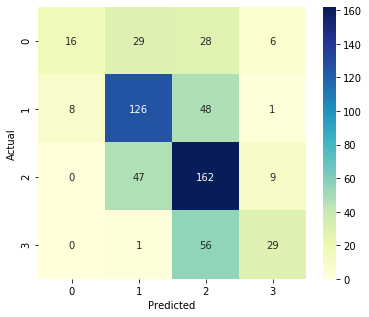

In [123]:
for i, (X, y) in enumerate(zip(list_X_test, list_y_test)):
    y_pred = model.predict(X)
    print('Model {}'.format(i+1))
    print("Accuracy:", accuracy_score(y, y_pred))
    print("F1 Score:", f1_score(y, y_pred, average='weighted'))
    print(classification_report(y, y_pred))
    
    conf_mat = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print("="*53)

## Model testing (binary model)

Model 0
Accuracy: 0.127208480565371
F1 Score: 0.1793889719956586
              precision    recall  f1-score   support

           0       1.00      0.09      0.17       262
           1       0.24      0.16      0.19       304
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.13       566
   macro avg       0.31      0.06      0.09       566
weighted avg       0.59      0.13      0.18       566



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


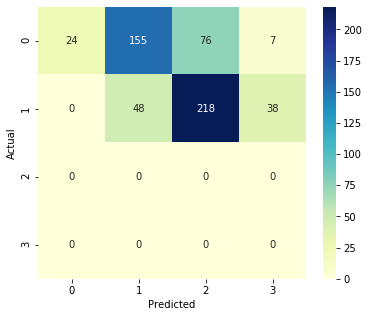

Model 1
Accuracy: 0.087248322147651
F1 Score: 0.11163732300790151
              precision    recall  f1-score   support

           0       1.00      0.03      0.07       489
           1       0.17      0.13      0.15       554
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.09      1043
   macro avg       0.29      0.04      0.05      1043
weighted avg       0.56      0.09      0.11      1043



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


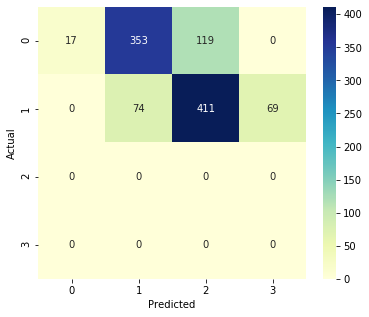

In [125]:
for i, (X, y) in enumerate(zip(list_X_bin_test, list_y_bin_test)):
    y_pred = model.predict(X)
    print('Model {}'.format(i+1))
    print("Accuracy:", accuracy_score(y, y_pred))
    print("F1 Score:", f1_score(y, y_pred, average='weighted'))
    print(classification_report(y, y_pred))
    
    conf_mat = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print("="*53)